In [1]:
# import libraries
import os
import time
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
# from tensorflow import set_random_seed
import tensorflow as tf
import logging
# tf.logging.set_verbosity(tf.logging.ERROR)

%load_ext autoreload
%autoreload 2
from fortadGAN.fortadGAN_utils import score_anomalies, reconstruction_errors
from fortadGAN.fortadGAN_layers import build_encoder_layer, build_generator_layer, build_critic_x_layer, build_critic_z_layer, wasserstein_loss
from fortadGAN.fortadGAN_preproc import time_segments_aggregate, rolling_window_sequences



from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers


# df.shape

In [3]:
seed(10)
# set_random_seed(10)

df = pd.read_csv('data/NYT.csv', index_col=0)
df_ano = pd.read_csv('data/NYT_ano.csv', index_col=0)
df.head()

,timestamp,value
0,1404165600,10844.0
1,1404167400,8127.0
2,1404169200,6210.0
3,1404171000,4656.0
4,1404172800,3820.0


# 데이터 jump 오류 있음
timestamp 에서 중간에 1800 기준으로 나타나지 않는 구간이 생기다 보니 문제가 생김
데이터 수에서도 문제가 생기기 때문에 이를 수정해줘서 데이터를 맞춰줌


In [98]:
st = df['timestamp'][0]
new_timestamp = list()
for i in range(len(df['timestamp'])):
    new_timestamp.append(st)
    st +=1800
df['new_timestamp'] = new_timestamp

In [122]:
new_start = list()
new_end = list()
for i in range(len(df_ano)):
    st_df = df.loc[df['timestamp'] == df_ano['start'][i]]
    ed_ef = df.loc[df['timestamp'] == df_ano['end'][i]]
    new_start.append(int(st_df['new_timestamp']))
    new_end.append(int(ed_ef['new_timestamp']))

df_ano['new_start'] = new_start
df_ano['new_end'] = new_end
df_ano
    

,start,end,new_start,new_end
0,1414679400,1415050200,1414675800,1415046600
1,1416913200,1417284000,1416909600,1417280400
2,1419330600,1419701400,1419327000,1419697800
3,1419885000,1420255800,1419881400,1420252200
4,1422127800,1422498600,1422124200,1422495000


In [124]:
del df['timestamp']
del df_ano['start']
del df_ano['end']

# 현재 데이터 시각화

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   value          10320 non-null  float64
 1   new_timestamp  10320 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 561.9 KB


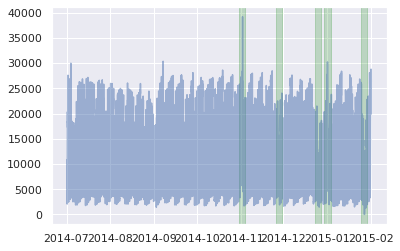

In [126]:
from datetime import datetime
def convert_date(timelist):
    converted = list()
    for x in timelist:
        converted.append(datetime.fromtimestamp(x))
    return converted

new_time = convert_date(df['new_timestamp'])

plt.plot(new_time, df['value'], alpha = 0.5)


for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)


plt.show()

# 데이터 처리

In [128]:
# 전처리 
print(df['value'].shape)
X, index = time_segments_aggregate(df, interval=1800, time_column='new_timestamp')
print(len(X))
print(len(index))
imp = SimpleImputer()
X = imp.fit_transform(X)
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
X, y = rolling_window_sequences(X, index, 
                                window_size=100, 
                                target_size=1, 
                                step_size=1)
print("Training data input shape: {}".format(X.shape))
print("Training y shape: {}".format(y.shape))
# X, y, X_index, y_index = rolling_window_sequences(X, index, 
#                                                   window_size=100, 
#                                                   target_size=1, 
#                                                   step_size=1)
# print("Training data input shape: {}".format(X.shape))
# print("Training data index shape: {}".format(X_index.shape))
# print("Training y shape: {}".format(y.shape))
# print("Training y index shape: {}".format(y_index.shape))
LOGGER = logging.getLogger(__name__)


(10320,)
10320
10320
Training data input shape: (10221, 100, 1)
Training y shape: (10221,)


/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [129]:
channel_size = 1
window_size = 100
latent_dim = 20
shape = (window_size, channel_size)

# Train parameters
batch_size = 64
n_critics = 5
epochs = 10

# Layer Parameters
encoder_input_shape = (window_size, channel_size)
generator_input_shape = (20, channel_size)

critic_x_input_shape = (window_size, channel_size)
critic_z_input_shape = (20,channel_size)

encoder_reshape_shape = (20, channel_size)
generator_reshape_shape = (window_size//2, channel_size) # window_size//3 <- 3 is Upsampling size

learning_rate = 0.0005

# Build Model
encoder = build_encoder_layer(input_shape=encoder_input_shape,
                              encoder_reshape_shape=encoder_reshape_shape)

generator = build_generator_layer(input_shape=generator_input_shape,
                                  generator_reshape_shape=generator_reshape_shape)

critic_x = build_critic_x_layer(input_shape=critic_x_input_shape)
critic_z = build_critic_z_layer(input_shape=critic_z_input_shape)

encoder_optimizer = tf.keras.optimizers.Adam(learning_rate)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_x_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_z_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [130]:
@tf.function
def critic_x_train_on_batch(x, z):
    # Loss 크게 이상 없음 
    with tf.GradientTape() as tape:
        x_ = generator(z)
        valid_x = critic_x(x)
        fake_x = critic_x(x_)
        
        # Interpolated 
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * x + (1 - alpha) * x_ 
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_x(interpolated)
        
        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0*tf.reduce_mean(tf.square(grad_norm - 1.))
                
        loss1 = wasserstein_loss(-tf.ones_like(valid_x), valid_x)
        loss2 = wasserstein_loss(tf.ones_like(fake_x), fake_x)
        loss = loss1 + loss2 + gp_loss
                        
    gradients = tape.gradient(loss, critic_x.trainable_weights)
    critic_x_optimizer.apply_gradients(zip(gradients, critic_x.trainable_weights))
    return loss


@tf.function
def critic_z_train_on_batch(x, z):
    
    with tf.GradientTape() as tape:

        z_ = encoder(x)   
        valid_z = critic_z(z)             
        fake_z = critic_z(z_) # <- critic_z 의 결과가 매우 않음 
        
        # Interpolated 
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * z + (1 - alpha) * z_ 
                
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_z(interpolated, training=True)
            
        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0*tf.reduce_mean(tf.square(grad_norm - 1.))
        
        loss1 = wasserstein_loss(-tf.ones_like(valid_z), valid_z)
        loss2 = wasserstein_loss(tf.ones_like(fake_z), fake_z) # <- 이게 미친듯이 뜀. 
        loss = loss1 + loss2 + gp_loss
        
    gradients = tape.gradient(loss, critic_z.trainable_weights)
    critic_z_optimizer.apply_gradients(zip(gradients, critic_z.trainable_weights))
    return loss


@tf.function
def enc_gen_train_on_batch(x, z):
    with tf.GradientTape() as enc_tape:
        
        z_gen_ = encoder(x, training=True)
        x_gen_ = generator(z, training=False)        
        x_gen_rec = generator(z_gen_, training=False)
        
        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)
        
        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0*tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        enc_loss = loss1 + loss2 + loss3
        
    gradients_encoder = enc_tape.gradient(enc_loss, encoder.trainable_weights)
    encoder_optimizer.apply_gradients(zip(gradients_encoder, encoder.trainable_weights))

    with tf.GradientTape() as gen_tape:
        
        z_gen_ = encoder(x, training=False)
        x_gen_ = generator(z, training=True)        
        x_gen_rec = generator(z_gen_, training=True)
        
        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)
        
        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0*tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        gen_loss = loss1 + loss2 + loss3
        
    gradients_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)    
    generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_weights))    
    return enc_loss, gen_loss

In [131]:
tf.config.experimental_run_functions_eagerly(True)

X = X.reshape((-1, shape[0], channel_size))
X_ = np.copy(X)

In [132]:
epoch_e_loss = []    
epoch_g_loss = []
epoch_cx_loss = []
epoch_cz_loss = []

for epoch in range(1, epochs+1):
    
    np.random.shuffle(X_)
    
    minibatches_size = batch_size * n_critics  # 64*5 = 320 
    num_minibatches = int(X_.shape[0] // minibatches_size)  # 12 
    
    encoder.trainable = False
    generator.trainable = False
    
    for i in range(num_minibatches):
        minibatch = X_[i * minibatches_size: (i + 1) * minibatches_size]
        
        # Number of Critics 
        for j in range(n_critics):
            
            x = minibatch[j * batch_size: (j + 1) * batch_size]
            ## 임의의 신호를 만들어서 집어 넣어주는 단계 (GAN을 학습시키기 위해 존재함)
            z = tf.random.normal(shape=(batch_size, latent_dim, channel_size), mean=0.0, stddev=1, dtype=tf.dtypes.float32, seed=1748)

            
            critic_x.trainable = True
            critic_z.trainable = False
            epoch_cx_loss.append(critic_x_train_on_batch(x, z))
            critic_x.trainable = False
            critic_z.trainable = True
            epoch_cz_loss.append(critic_z_train_on_batch(x, z))
        
        critic_z.trainable = False
        critic_x.trainable = False
        encoder.trainable = True
        generator.trainable = True
        
        enc_loss, gen_loss = enc_gen_train_on_batch(x, z)
        epoch_e_loss.append(enc_loss)
        epoch_g_loss.append(gen_loss)
        
    cx_loss = np.mean(np.array(epoch_cx_loss), axis=0)
    cz_loss = np.mean(np.array(epoch_cz_loss), axis=0)
    e_loss = np.mean(np.array(epoch_e_loss), axis=0)
    g_loss = np.mean(np.array(epoch_g_loss), axis=0)
    
    print('Epoch: {}/{}, [Dx loss: {}] [Dz loss: {}] [E loss: {}] [G loss: {}]'.format(epoch, epochs, cx_loss, cz_loss, e_loss, g_loss))    

Epoch: 1/10, [Dx loss: -1.0679785013198853] [Dz loss: -2.0631730556488037] [E loss: 2.309176206588745] [G loss: 1.57382333278656]
Epoch: 2/10, [Dx loss: -1.0897953510284424] [Dz loss: -1.960183024406433] [E loss: -0.9672163724899292] [G loss: -1.4504497051239014]
Epoch: 3/10, [Dx loss: -1.0188275575637817] [Dz loss: -1.9359155893325806] [E loss: -1.2264163494110107] [G loss: -1.5807491540908813]
Epoch: 4/10, [Dx loss: -0.946418046951294] [Dz loss: -1.934537649154663] [E loss: -0.550866425037384] [G loss: -0.8468795418739319]
Epoch: 5/10, [Dx loss: -0.8689168691635132] [Dz loss: -1.8796818256378174] [E loss: 0.48949378728866577] [G loss: 0.2238738089799881]
Epoch: 6/10, [Dx loss: -0.8203033208847046] [Dz loss: -1.8116134405136108] [E loss: 0.8664568066596985] [G loss: 0.6136610507965088]
Epoch: 7/10, [Dx loss: -0.7826656699180603] [Dz loss: -1.6567052602767944] [E loss: 1.1663707494735718] [G loss: 0.9066742658615112]
Epoch: 8/10, [Dx loss: -0.7510477304458618] [Dz loss: -1.633484482765

# 재구축

In [133]:

def reconstruction(X):
    z_gen_ = encoder(X, training=False)
    x_gen_ = generator(z_gen_, training=False)
    X_critic = critic_x(x_gen_, training=False)
    return x_gen_, X_critic

X_gen, X_critic = reconstruction(X)

final_scores = score_anomalies(X, X_gen, X_critic, rec_error_type="point", comb="mult")

In [134]:
print(X.shape)
print(X_gen.shape)
print(final_scores.shape)

(10221, 100, 1)
(10221, 100, 1)
(10320, 1)


In [138]:
np.save('/home/rain/anomaly_detection/NYT/result/tadGAN_X.npy', X)
np.save('/home/rain/anomaly_detection/NYT/result/tadGAN_X_gen.npy', X_gen)
np.save('/home/rain/anomaly_detection/NYT/result/tadGAN_final.npy', final_scores)

/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


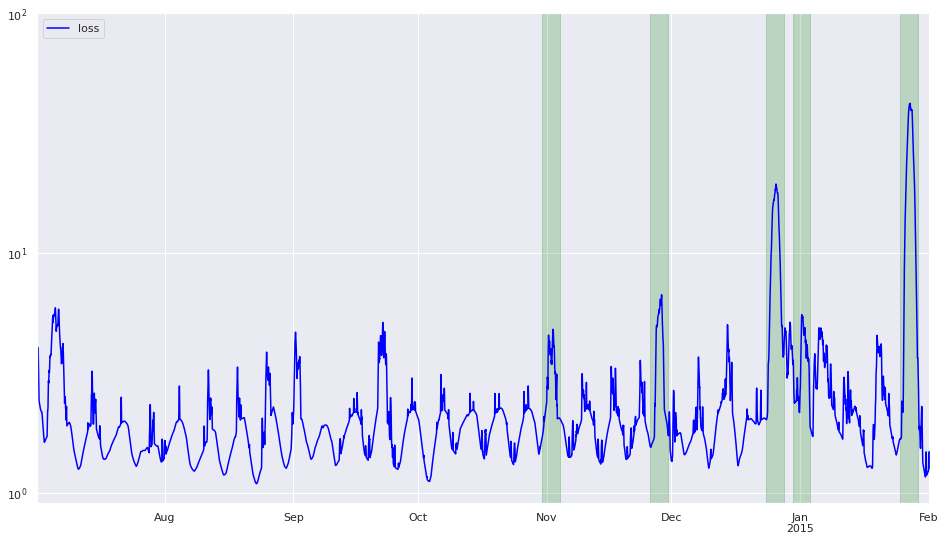

In [137]:
scored = pd.DataFrame(index=new_time)
scored['loss'] = final_scores[:]
scored.plot(logy=True,  figsize=(16,9), ylim=[0,1e2], color=['blue','red', 'orange', 'green', 'magenta'])
for st_ed_times in df_ano.values:
    st = datetime.fromtimestamp(st_ed_times[0])
    ed = datetime.fromtimestamp(st_ed_times[1])
    plt.axvspan(st, ed, color='green', alpha=0.2)